In [12]:
import os
import math
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('darkgrid')
%matplotlib inline

# Core libraries
import numpy as np
import pandas as pd

# Preprocessing and model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

# Pipeline utilities
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Other packages
from dython.nominal import associations
from mlxtend.plotting import plot_decision_regions
from itertools import chain
from random import seed, shuffle
from scipy.optimize import minimize 
from multiprocessing import Pool, Process, Queue
from collections import defaultdict
from copy import deepcopy


import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
# Function to preprocess the dataset
def preprocess_data(df):
    """
    Function to preprocess the dataset.

    Parameters:
    df: DataFrame, the original dataset.

    Returns:
    X: DataFrame, preprocessed feature dataset.
    y: ndarray, target variable.
    x_sensitive: Series, sensitive attribute data.
    """
    # Select data for 'African-American' and 'Caucasian' races
    data = df[(df['race']=='African-American') | (df['race']=='Caucasian')]
    
    # Calculate length of stay
    data["length_of_stay"] = (pd.to_datetime(data.c_jail_out) - pd.to_datetime(data.c_jail_in)).astype('timedelta64[D]')
    
    # Filter data within 30 days before and after screening arrest and remove columns with many missing values
    data = data[(data.days_b_screening_arrest <= 30) & (data.days_b_screening_arrest >= -30)]
    data = data[data.is_recid != -1]
    data = data[data.c_charge_degree != "O"]
    data = data[data.score_text != "N/A"]
    
    # Drop unnecessary columns
    data.drop(['first','last','c_case_number','c_charge_desc','violent_recid','vr_charge_degree','vr_case_number','vr_offense_date','vr_charge_desc',
              'c_arrest_date','r_jail_out','r_jail_in','r_days_from_arrest','r_charge_desc',
              'r_offense_date','r_case_number','r_charge_degree'], axis=1, inplace=True)
    
    # Handle missing values
    data['c_days_from_compas'] = data['c_days_from_compas'].fillna(data['c_days_from_compas'].mode()[0])
    data = data.dropna()

    # Extract features and target variable
    X = data.drop(['id','two_year_recid','dob','name','v_type_of_assessment','type_of_assessment'], axis=1)
    X.set_index(data.id,inplace=True)
    y = data[['two_year_recid']]
    y.set_index(data.id,inplace=True)
    X = X.drop(['c_offense_date','c_jail_in','c_jail_out','out_custody','in_custody','screening_date','compas_screening_date','v_screening_date'],axis=1)

    # Encode categorical variables
    X['race'] = X['race'].replace(['African-American','Caucasian'], [0, 1.0])
    X['sex'] = X['sex'].replace(['Male','Female'], [0, 1.0])
    X['age_cat'] = X['age_cat'].replace(['25 - 45','Less than 25', 'Greater than 45'], [0, 1.0, 2.0])
    X['c_charge_degree'] = X['c_charge_degree'].replace(['M','F'], [0, 1.0])
    X['score_text'] = X['score_text'].replace(['Low', 'High', 'Medium'], [0, 1.0, 2.0])
    X['v_score_text'] = X['v_score_text'].replace(['Low', 'High', 'Medium'], [0, 1.0, 2.0])

    # Fill missing values
    X = X.fillna(0)
    y = np.array(y)

    return X, y

In [3]:
# Function to prepare training and testing sets
def prepare_train_test_sets(X, y, test_size=0.2, random_state=42):
    """
    Function to prepare training and testing sets.

    Parameters:
    X: DataFrame, feature dataset.
    y: ndarray, target variable.
    x_sensitive: Series, sensitive attribute data.
    test_size: float, size of the test set, default is 0.1.
    random_state: int, random seed, default is 44.

    Returns:
    X_train: DataFrame, training set feature data.
    X_test: DataFrame, testing set feature data.
    y_train: ndarray, training set target variable.
    y_test: ndarray, testing set target variable.
    x_sensitive_tr: Series, training set sensitive attribute data.
    x_sensitive_te: Series, testing set sensitive attribute data.
    """
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    x_sensitive_tr = X_train.loc[:, 'race']
    x_sensitive_te = X_test.loc[:, 'race']
    X_train = X_train.loc[:, X_train.columns != 'race']
    X_test = X_test.loc[:, X_test.columns != 'race']

    X_train=X_train.reset_index()
    X_test=X_test.reset_index()
    x_sensitive_tr=x_sensitive_tr.reset_index()
    x_sensitive_te=x_sensitive_te.reset_index()

    X_train=X_train.drop(['id'], axis=1)
    X_test=X_test.drop(['id'], axis=1)
    x_sensitive_tr=x_sensitive_tr.drop(['id'], axis=1)
    x_sensitive_te=x_sensitive_te.drop(['id'], axis=1)

    return X_train, X_test, y_train, y_test, x_sensitive_tr, x_sensitive_te


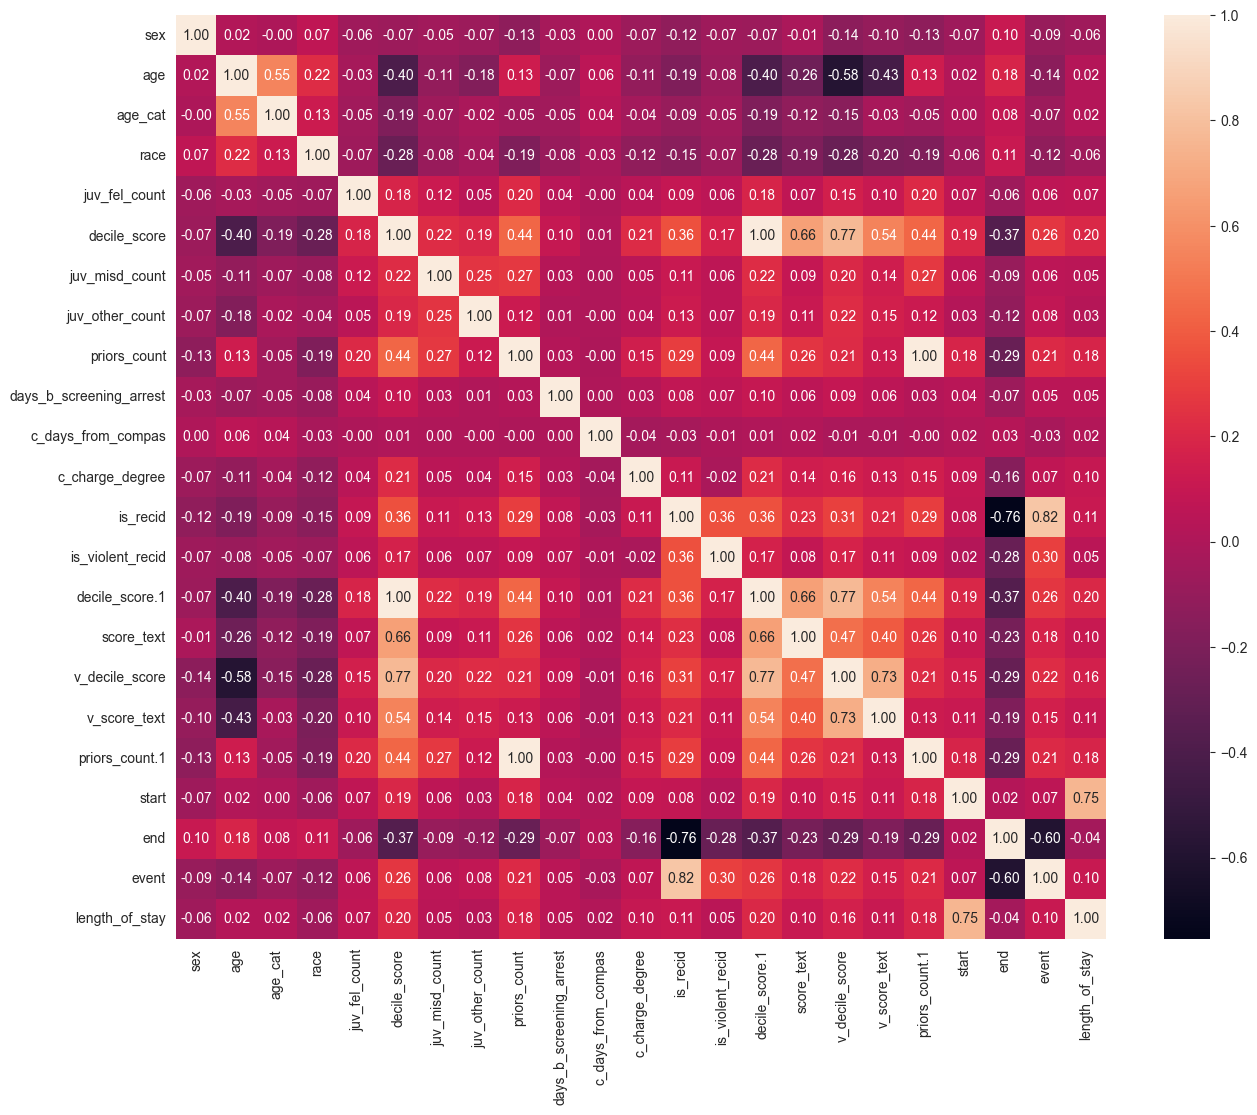

In [4]:
# Load the data
raw_data = '../data/compas-scores-two-years.csv'
df = pd.read_csv(raw_data)

# Preprocess the data
X, y = preprocess_data(df)

corr = X.corr()
fig,ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

In [5]:
# model evaluation
def calculate_calibration_difference(predictions, actual_labels, sensitive_attributes):
    """
    Calculate the difference in calibration between two groups based on predictions.

    Parameters:
    predictions: list, predicted labels.
    actual_labels: list, true labels.
    sensitive_attributes: list, sensitive attribute values (e.g., race).

    Returns:
    calibration_difference: float, difference in calibration between the two groups.
    """
    calibration_group_0 = 0
    calibration_group_1 = 0
    correct_predictions_group_0 = 0
    correct_predictions_group_1 = 0

    for i in range(len(predictions)):
        if sensitive_attributes[i] == 0:  # Group 0
            correct_predictions_group_0 += 1 if predictions[i] == actual_labels[i] else 0
        else:  # Group 1
            correct_predictions_group_1 += 1 if predictions[i] == actual_labels[i] else 0

    # Avoid division by zero
    total_predictions_group_0 = max(sum(s == 0 for s in sensitive_attributes), 1)
    total_predictions_group_1 = max(sum(s != 0 for s in sensitive_attributes), 1)

    # Calculate calibration scores for each group
    calibration_group_0 = correct_predictions_group_0 / total_predictions_group_0
    calibration_group_1 = correct_predictions_group_1 / total_predictions_group_1

    # Calculate the difference in calibration between the two groups
    calibration_difference = calibration_group_0 - calibration_group_1

    return calibration_difference


# baseline

In [6]:
# Prepare training and testing sets
X_train, X_test, y_train, y_test, x_sensitive_tr, x_sensitive_te = prepare_train_test_sets(X, y)
model_base = LogisticRegression(fit_intercept=False).fit(X_train,y_train.flatten())
base_y_train = model_base.predict(X_train)
base_y_test = model_base.predict(X_test)

theta_star = model_base.coef_.flatten()

#metrics
print('train accuracy: ' + str(model_base.score(X_train,y_train.flatten())))
print('test accuracy: ' + str(model_base.score(X_test,y_test.flatten())))

base_calib_train = calculate_calibration_difference(base_y_train, y_train.flatten(),x_sensitive_tr['race'].values)
base_calib_test = calculate_calibration_difference(base_y_test, y_test.flatten(),x_sensitive_te['race'].values)

print('train calibration: ' + str(base_calib_train))
print('test calibration: ' + str(base_calib_test))

train accuracy: 0.9550531190411332
test accuracy: 0.9553376906318083
train calibration: -0.0029286615479778844
test calibration: 0.007094861660078999


# Handling Conditional Discrimination

In [7]:
import pandas as pd

def preprocess_data_new(df):
    """
    Preprocess the dataset.

    Parameters:
    df: DataFrame, the original dataset.

    Returns:
    X: DataFrame, preprocessed feature dataset.
    y: DataFrame, target variable.
    """
    # Select data for 'African-American' and 'Caucasian' races
    data = df[(df['race']=='African-American')|(df['race']=='Caucasian')]

    # Drop unnecessary columns
    data.drop(['violent_recid','vr_charge_degree','vr_case_number','vr_offense_date','vr_charge_desc',
               'c_arrest_date','r_jail_out','r_jail_in','r_days_from_arrest','r_charge_desc',
               'r_offense_date','r_case_number','r_charge_degree'], axis=1, inplace=True)

    # Convert date columns to datetime format
    date_columns = ['c_offense_date', 'c_jail_in', 'c_jail_out', 'out_custody', 'in_custody',
                    'screening_date', 'compas_screening_date', 'v_screening_date']
    data[date_columns] = data[date_columns].apply(pd.to_datetime)

    # Fill missing values in 'c_days_from_compas' column with the mode
    data['c_days_from_compas'] = data['c_days_from_compas'].fillna(data['c_days_from_compas'].mode()[0])

    # Drop unnecessary columns and set index
    X = data.drop(['id','two_year_recid','c_case_number','sex','dob','name'], axis=1)
    X.set_index(data.id, inplace=True)

    # Calculate recidivism rates for African-American and Caucasian groups
    af = data[data.race=='African-American']
    ca = data[data.race =='Caucasian']
    rate_af = round(af[af['two_year_recid']==1].shape[0]/af.shape[0], 2)
    rate_ca = round(ca[ca['two_year_recid']==1].shape[0]/af.shape[0], 2)
    corrected_rate = round((rate_af + rate_ca) / 2, 2)
    print(f'The rate of Recidivism for African-American is {rate_af}\nThe rate of Recidivism for Caucasian is {rate_ca}')
    print(f'The Corrected Recidivism rate should be {corrected_rate:,}')

    # Target variable
    y = data[['two_year_recid']]
    y.set_index(data.id, inplace=True)

    return X, y

The rate of Recidivism for African-American is 0.51
The rate of Recidivism for Caucasian is 0.26
The Corrected Recidivism rate should be 0.39


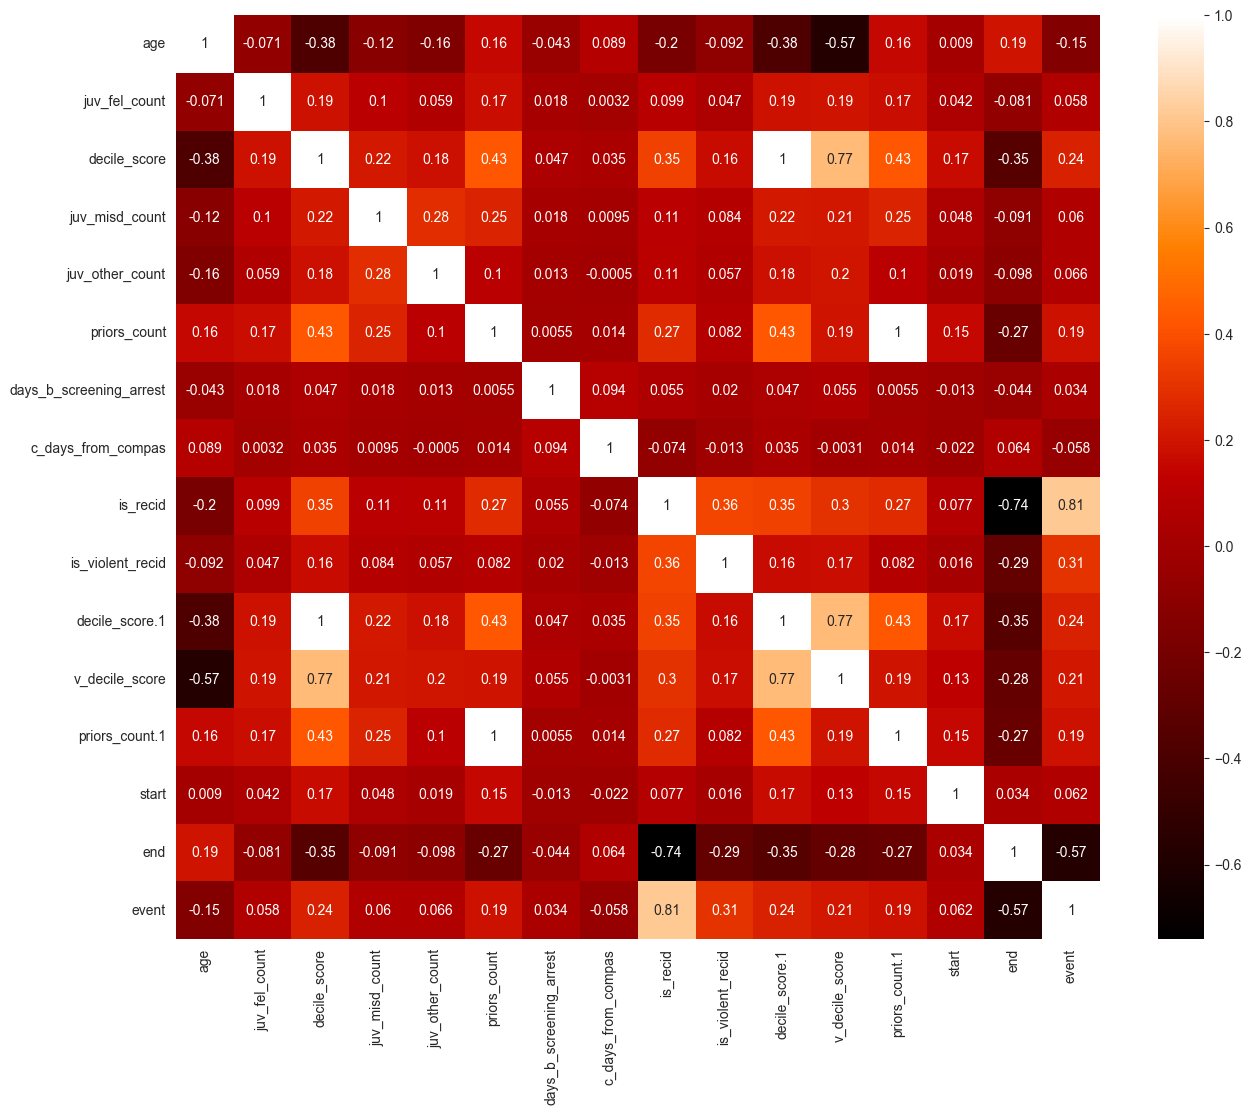

In [8]:
# Preprocess the data
X, y = preprocess_data_new(df)
corr = X.corr()
fig,ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr, annot=True, square=True, cmap='gist_heat')
plt.show()

In [9]:
enc = OneHotEncoder(handle_unknown='ignore')
X_new = enc.fit(X)
X_new = enc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.2,random_state=42)

# random_forest

In [14]:
forest = RandomForestClassifier(random_state=42).fit(X_train, y_train) 
y_pred_test = forest.predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']

0.9658536585365853
[[617  35]
 [  7 571]]


# xgboost model

In [15]:
xgb_model = xgb.XGBClassifier(random_state=42).fit(X_train, y_train)
y_pred_test = xgb_model.predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

0.9691056910569106
[[617  35]
 [  3 575]]
0.011325799270383463


# lightgbm model

In [61]:
params = {
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'max_depth': -1,
    'max_bin': 10,
    'learning_rate': 0.01,
    'n_estimators': 50,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'random_state': 42
}
gbm = lgb.LGBMClassifier(**params)
gbm.fit(X_train, y_train)
y_pred_test = gbm.predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

[LightGBM] [Info] Number of positive: 2289, number of negative: 2631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 4920, number of used features: 296
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465244 -> initscore=-0.139249
[LightGBM] [Info] Start training from score -0.139249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [16]:
categorical_features = ['first','last','age_cat','race','c_charge_degree','c_charge_desc','type_of_assessment',
                       'score_text','v_type_of_assessment','v_score_text']

In [17]:
selected_column= X[categorical_features]
categorical_df = selected_column.copy()

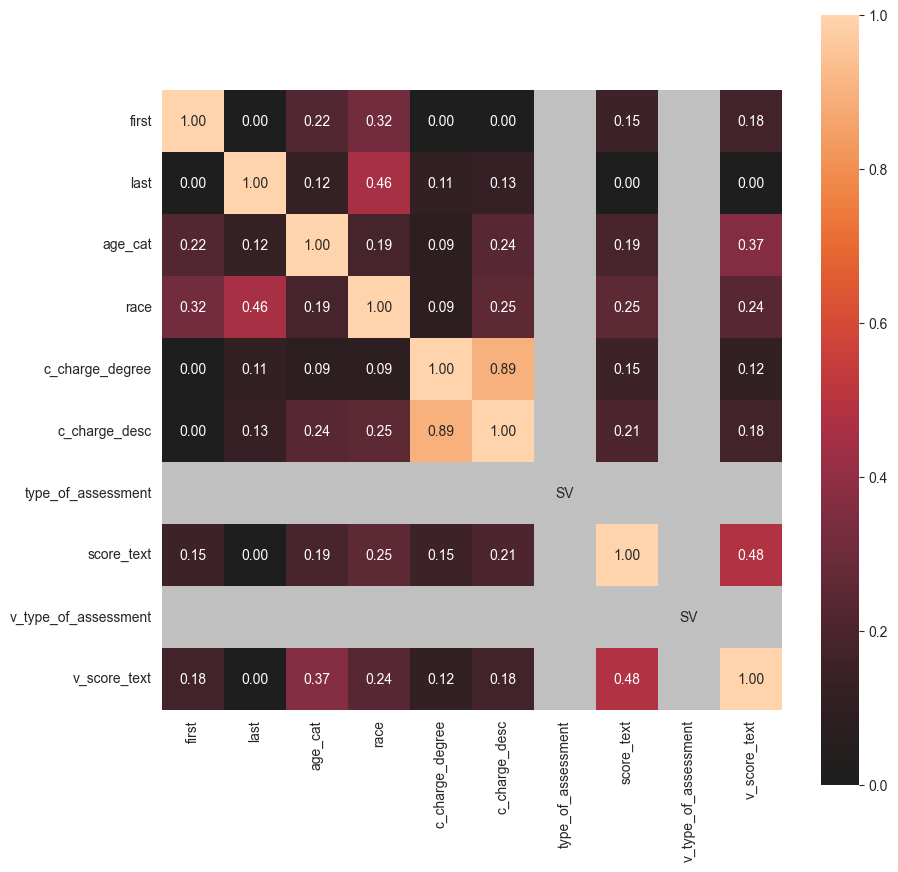

In [18]:
categorical_correlation= associations(categorical_df, filename= 'categorical_correlation.png', figsize=(10,10))

In [19]:
e_list = ['first', 'last', 'c_charge_desc', 'score_text' , 'v_score_text']
exclude_list = [
 'compas_screening_date',
 'age',
 'age_cat',
 'juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_jail_in',
 'c_jail_out',
 'c_offense_date',
 'c_days_from_compas',
 'c_charge_degree',
 'is_recid',
 'is_violent_recid',
 'type_of_assessment',
 'decile_score.1',
 'screening_date',
 'v_type_of_assessment',
 'v_decile_score',
 'v_screening_date',
 'in_custody',
 'out_custody',
 'priors_count.1',
 'start',
 'end',
 'event']


# Local Massaging

In [35]:
def partition_data(X, sensitive_attributes):
    """
    Partition the data based on sensitive attributes.

    Args:
    X (DataFrame): Input data.
    sensitive_attributes (dict): Dictionary containing sensitive attribute values.

    Returns:
    list: List of partitioned data.
    """
    partitions = []
    for attr, value in sensitive_attributes.items():
        X_copy = X.copy()
        X_copy[attr] = value
        partitions.append(X_copy)
    return partitions

def adjust_predictions(data_item, y_pred, y_probabilities, fairness_threshold=12):
    """
    Adjust predictions based on fairness constraints.

    Args:
    data_item (DataFrame): Data item.
    y_pred (array): Predicted labels.
    y_probabilities (array): Predicted probabilities.
    fairness_threshold (int): Hyperparameter for fairness adjustment.

    Returns:
    DataFrame: Adjusted data.
    """
    data_copy = data_item.copy()
    data_copy['label'] = y_pred
    african_americans = data_copy[data_copy['race'] == 'African-American']
    caucasians = data_copy[data_copy['race'] == 'Caucasian']
    african_american_rate = round(african_americans[african_americans['label'] == 1].shape[0] / african_americans.shape[0], 2)
    caucasian_rate = round(caucasians[caucasians['label'] == 1].shape[0] / caucasians.shape[0], 2)
    p_star = (african_american_rate + caucasian_rate) / 2
    threshold = np.abs(african_american_rate - p_star)

    probabilities_df = pd.DataFrame(y_probabilities, columns=['No', 'Yes'])
    probabilities_df.set_index(data_item.index, inplace=True)
    probabilities_df['race'] = data_item['race']
    probabilities_df['label'] = y_pred
    temp = probabilities_df[(np.abs(probabilities_df['Yes'] - probabilities_df['No']) <= fairness_threshold * threshold)]

    for i in range(temp.shape[0]):
        if temp['race'].iloc[i] == 'African-American' and temp['Yes'].iloc[i] > temp['No'].iloc[i]:
            temp['label'].iloc[i] = 0
        elif temp['race'].iloc[i] == 'Caucasian' and temp['Yes'].iloc[i] < temp['No'].iloc[i]:
            temp['label'].iloc[i] = 1

    data_copy['label'].loc[temp.index] = temp['label']

    return data_copy

def local_massaging(X, sensitive_attribute_value, sensitive_attributes, y):
    """
    Apply local massaging technique for fairness-aware classification.

    Args:
    X (DataFrame): Input data.
    sensitive_attribute_value (str): Value of the sensitive attribute.
    sensitive_attributes (dict): Dictionary containing sensitive attribute values.
    y (Series): Target labels.

    Returns:
    DataFrame: Data with adjusted labels.
    """
    X['race'] = sensitive_attribute_value
    data_partitions = partition_data(X, sensitive_attributes)
    adjusted_data = []
    for item in data_partitions:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoded_data = encoder.fit_transform(item)
        X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, test_size=.2, random_state=5)
        forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)
        y_pred = forest.predict(encoded_data)
        y_prob = forest.predict_proba(encoded_data)
        temp_df = adjust_predictions(item, y_pred, y_prob)
        adjusted_data.append(temp_df[['label']])

    result = pd.concat(adjusted_data, axis=1)
    result.loc[result.sum(axis=1) <= 2, 'new_label'] = 0
    result.loc[result.sum(axis=1) >= 3, 'new_label'] = 1
    X['new_label'] = result['new_label']
    return X

In [ ]:
New_X = local_massaging(X[exclude_list], X[['race']], X[e_list], y)
af = New_X[New_X.race=='African-American']
ca = New_X[New_X.race =='Caucasian']
rate_af = round(af[af['new_label']==1].shape[0]/af.shape[0],2)
rate_ca = round(ca[ca['new_label']==1].shape[0]/ca.shape[0],2)

In [ ]:
rate_af,rate_ca 

# new_label

In [ ]:
New_y = New_X.new_label
New_X_copy = New_X.copy()
New_X_copy.drop(['new_label'],axis=1,inplace=True)
X_new = enc.fit(New_X_copy)
X_new = enc.transform(New_X_copy)
X_train, X_test, y_train, y_test = train_test_split(X_new,New_y,test_size=.2,random_state=42)
forest = RandomForestClassifier(random_state=42).fit(X_train, y_train) 
y_pred_test = forest.predict(X_test)

In [26]:
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = New_X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

0.959349593495935
[[927  62]
 [ 13 843]]
0.0472145615002757


# Local Preferential Sampling

In [31]:
def ceildiv(a, b):
    """
    Calculate the ceiling division of two numbers.

    Args:
    - a (int): Numerator.
    - b (int): Denominator.

    Returns:
    - int: Ceiling division result.
    """
    return -(a // -b)

def adjust_labels(item_data, predicted_labels, predicted_probabilities, fairness_threshold=6):
    """
    Adjust predicted labels based on fairness criteria.
    
    Args:
    - item_data (DataFrame): Input data.
    - predicted_labels (array-like): Predicted labels.
    - predicted_probabilities (array-like): Predicted probabilities.
    - fairness_threshold (int, optional): Threshold for fairness adjustment. Default is 6.
    
    Returns:
    - DataFrame: Data with adjusted labels.
    """
    
    data_copy = item_data.copy()
    data_copy['predicted_label'] = predicted_labels
    african_american_data = data_copy[data_copy.race == 'African-American']
    caucasian_data = data_copy[data_copy.race == 'Caucasian']
    rate_af = round(african_american_data[african_american_data['predicted_label'] == 1].shape[0] / african_american_data.shape[0], 2)
    rate_ca = round(caucasian_data[caucasian_data['predicted_label'] == 1].shape[0] / caucasian_data.shape[0], 2)
    p_star = (rate_af + rate_ca) / 2
    threshold = np.abs(rate_af - p_star)

    test_df = pd.DataFrame(predicted_probabilities, columns=['No', 'Yes'])
    test_df.set_index(item_data.index, inplace=True)
    test_df['race'] = item_data['race']
    test_df['predicted_label'] = predicted_labels
    filtered_data = test_df[(np.abs(test_df.Yes - test_df.No) <= fairness_threshold * threshold)]
    filtered_data_dict = filtered_data[['race', 'predicted_label']].value_counts().to_dict()

    aa_0, aa_1, ca_0, ca_1 = 0, 0, 0, 0
    for key, value in zip(filtered_data_dict.keys(), filtered_data_dict.values()):
        if key == ('African-American', 1):
            aa_1 = ceildiv(value, 2)
        if key == ('African-American', 0):
            aa_0 = ceildiv(value, 2)
        if key == ('Caucasian', 1):
            ca_1 = ceildiv(value, 2)
        if key == ('Caucasian', 0):
            ca_0 = ceildiv(value, 2)

    if aa_1 > aa_0:
        aa_replace = aa_0
    else:
        aa_replace = aa_1

    if ca_1 > ca_0:
        ca_replace = ca_0
    else:
        ca_replace = ca_1

    count_aa = 0
    count_ca = 0

    while count_aa < aa_replace:
        for idx in list(filtered_data.index):
            if filtered_data.race.loc[idx] == 'African-American' and filtered_data.predicted_label.loc[idx] == 1:
                filtered_data.predicted_label.loc[idx] = 0
                count_aa += 1

    while count_ca < ca_replace:
        for idx in list(filtered_data.index):
            if filtered_data.race.loc[idx] == 'Caucasian' and filtered_data.predicted_label.loc[idx] == 0:
                filtered_data.predicted_label.loc[idx] = 1
                count_ca += 1

    data_copy['predicted_label'].loc[filtered_data.index] = filtered_data.predicted_label

    return data_copy


def local_preferential_sampling(input_features, race_info, partition_size, target_labels):
    """
    Apply local preferential sampling technique.
    
    Args:
    - input_features (DataFrame): Input features.
    - race_info (array-like): Race information.
    - partition_size (int): Size of partition.
    - target_labels (array-like): Target labels.
    
    Returns:
    - DataFrame: Data with adjusted labels.
    """
    
    input_features['race'] = race_info
    partitioned_data_list = partition_data(input_features, partition_size)
    dataframe_list = []
    prediction_data_list = []
    for data_partition in partitioned_data_list:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoded_data = encoder.fit_transform(data_partition)
        X_train, X_test, y_train, y_test = train_test_split(encoded_data, target_labels, test_size=.3, random_state=42)
        forest_classifier = RandomForestClassifier(random_state=88).fit(X_train, y_train)
        predicted_labels = forest_classifier.predict(encoded_data)
        predicted_probabilities = forest_classifier.predict_proba(encoded_data)
        adjusted_data = adjust_labels(data_partition, predicted_labels, predicted_probabilities, 6)
        prediction_data_list.append(adjusted_data)
        dataframe_list.append(adjusted_data[['predicted_label']])

    result_dataframe = pd.concat(dataframe_list, axis=1)
    result_dataframe.loc[result_dataframe.sum(axis=1) <= 2, 'new_label'] = 0
    result_dataframe.loc[result_dataframe.sum(axis=1) >= 3, 'new_label'] = 1
    input_features['new_label'] = result_dataframe.new_label

    return input_features


In [32]:
X_New = local_preferential_sampling(X[exclude_list], X[['race']], X[e_list], y)
af = X_New[X_New.race=='African-American']
ca = X_New[X_New.race =='Caucasian']
rate_af = round(af[af['new_label']==1].shape[0]/af.shape[0],2)
rate_ca = round(ca[ca['new_label']==1].shape[0]/ca.shape[0],2)
rate_af,rate_ca

(0.51, 0.41)

# new_label2

In [33]:
y_New = X_New.new_label
X_New_copy = X_New.copy()
X_New_copy.drop(['new_label'],axis=1,inplace=True)
X_new = enc.fit(X_New_copy)
X_new = enc.transform(X_New_copy)
X_train, X_test, y_train, y_test = train_test_split(X_new,y_New,test_size=.2,random_state=42)
forest = RandomForestClassifier(random_state=42).fit(X_train, y_train) 
y_pred_test = forest.predict(X_test)

In [34]:
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = X_New.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

0.9821138211382113
[[618  22]
 [  0 590]]
0.030013642564802212
